# Optimal network reinforcement solution for distributed generation rise.

Description of the project

In [7]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections,create_trafo_collection
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Functions

In [76]:
#Initialisation
def Init(pmw_gen=10):
    net = pn.mv_oberrhein("generation")
    #Calculate the length of the lines
    for i,length in zip(net.line.index,net.line['length_km']):
        x1,y1 = float(net.bus_geodata['x'][net.line['from_bus'][i]]), float(net.bus_geodata['y'][net.line['from_bus'][i]])
        x2,y2 = float(net.bus_geodata['x'][net.line['to_bus'][i]]), float(net.bus_geodata['y'][net.line['to_bus'][i]])
        net.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)/300 #factor for convergence
    #Move position of external grid in order to be able to see the transformer
    net.bus_geodata['x'][318], net.bus_geodata['y'][318] = 3408302.042,5367780.101
    net.bus_geodata['x'][58], net.bus_geodata['y'][58] = 3420000.660 , 5369458.703
    #Drop all already in static generators
    #for i,_ in enumerate(net.sgen['p_mw']):
    #    net.sgen = net.sgen.drop(i)
    #Creating the generator
    x_gen, y_gen = 3410832.464,5368594.558 #Determine on QGis
    pp.create_bus(net,geodata=(x_gen,y_gen),vn_kv=20.0,min_vm_pu=0.9,max_vm_pu=1.1,name='Bus 179',index=320)
    #Create generator at the created node (200)
    pp.create_gen(net,320,p_mw=pmw_gen) #Change the p_mw, max and min value?
    return net

#Technical violation functions
    #Visual plot
def Plot(net,saveName = None): #Plot map with in red the problematic(s) line(s),node(s) or transformator(s)
    # plot network with color codes
    cmap_list_node = [((0,0.9), "orangered"), ((0.9,1.1), "blue"), ((1.1,2), "red")]
    cmap_n, norm_n = cmap_discrete(cmap_list_node)
    bc = create_bus_collection(net, size=70, cmap=cmap_n, norm=norm_n);
    
    cmap_list_line = [((0, 95), "green"),((95,100),"yellow"), ((100, 200), "red")]
    cmap_l, norm_l = cmap_discrete(cmap_list_line)
    lc = create_line_collection(net, cmap=cmap_l, norm=norm_l,use_bus_geodata=True)
    
    cmap_list_trafo = [((0, 95), "lightgreen"),((95,100),"gold"), ((100, 200), "tomato")]
    cmap_t, norm_t = cmap_discrete(cmap_list_trafo)
    tc = create_trafo_collection(net,cmap=cmap_t, norm=norm_t)
    
    draw_collections([bc,tc,lc])
    plt.savefig(saveName) if saveName !=None else None

    # check constraints violation - voltage - bus
def isVoltageViolation(net):
    vMin,vMax, Node = 0.9, 1.1, [] #Init
    for k,v in enumerate(net.res_bus['vm_pu']):
        if v>vMax or v<vMin: #if violation
            Node.append(k)  #save the bus index
    return Node

    # check constraints violation - current - line
def isCurrentViolation(net):
    iMax, Line = net.line['max_i_ka'], [] #Init
    for k,i in zip(net.line.index,net.res_line['i_ka']):
        if i>iMax[k]: #if violation
            Line.append(k) #save the line index
    return Line

    # check constraints violation - load - transformer
def isTransformerViolation(net):
    loadmax, Trafo = 100, []
    for k, t in enumerate(net.res_trafo['loading_percent']):
        if t>loadmax: #if violation
            Trafo.append(k) #save the trafo index
    return Trafo
    
    #Return boolean of "is there violation?" with the value of bus, line and transfo that the limiting factor.
def isThereViolation(net,plot=False,saveName=None):
    if plot:
        Plot(net,saveName)
    N,L,T = isVoltageViolation(net),  isCurrentViolation(net),  isTransformerViolation(net)
    if N!=[] or L!=[] or T!=[]:
        return [True, N, L , T]
    return [False, N, L, T]

#Function of connexion

def CreateLine20kV(net,nod1,nod2,plot=True,saveName=None):
    x1,y1 = float(net.bus_geodata['x'][net.bus_geodata.index==nod1]), float(net.bus_geodata['y'][net.bus_geodata.index==nod1])
    x2,y2 = float(net.bus_geodata['x'][net.bus_geodata.index==nod2]), float(net.bus_geodata['y'][net.bus_geodata.index==nod2])
    len_con = np.sqrt((x2-x1)**2+(y2-y1)**2)/300 #factor for convergence
    pp.create_line(net,nod1,nod2,length_km=len_con,std_type="243-AL1/39-ST1A 20.0")
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=None),len_con

    #Connect the generator to the network at bus "node". plot the line
def ConnexionGen(net, node, plot=True,saveName=None):
    x_nod = float(net.bus_geodata['x'][net.bus_geodata.index==node])
    y_nod = float(net.bus_geodata['y'][net.bus_geodata.index==node])
    x_gen, y_gen = 3410832.464,5368594.558 #Determine on QGis
    len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2)/300 #factor for convergence
    if net.bus.vn_kv[node] == net.bus.vn_kv[320]:
        pp.create_line(net,320,node,length_km=len_con,std_type="243-AL1/39-ST1A 20.0") #generator at bus 320
        T = False
    else:
        pp.create_bus(net,geodata=(x_gen+0.1,y_gen+0.1),vn_kv=110.0,min_vm_pu=0.9,max_vm_pu=1.1,name='Bus 180',index=321)
        pp.create_transformer(net,321,320,std_type="63 MVA 110/20 kV")
        pp.create_line(net,321,node,length_km=len_con,std_type="149-AL1/24-ST1A 110.0") #generator at bus 320
        T = True #say if a transformer was needed or not
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=saveName),len_con,T

def DoubleCon(net,node1,node2,plot=True,saveName=None):
    _,lent1,T1 = ConnexionGen(net,node1,plot=False)
    PB,lent2,T2 = ConnexionGen(net,node2,plot=plot,saveName=saveName)
    return PB,[lent1,lent2],np.max([T1,T2])
    

    #Change the problematic component (for now just lines)
def ChangeComp(net,id_node,id_line,id_trafo, pmw_gen=10,plot=True,saveName=None):
    net.gen.p_mw[0] = pmw_gen
    LengthSout, LengthAer,Ori,TCh = 0,0,False, 0
    for l in id_line:
        Origin = False #set for each line that it is not the connexion line
        if net.line.from_bus[l] == 320:
            Origin,Ori = True, True #set for this line Origin -> not consider the length as changed + say that it has been changed (change cost)
        fromb,tob,lenb,std_type = net.line['from_bus'][l],net.line['to_bus'][l],net.line['length_km'][l], net.line['std_type'][l] #extract data
        net.line = net.line.drop(l) #drop the problematic line
        if std_type == 'NA2XS2Y 1x185 RM/25 12/20 kV' or std_type=='N2XS(FL)2Y 1x300 RM/35 64/110 kV': 
            #distinction between underground and overhead cable
            pp.create_line(net,fromb,tob,length_km=lenb,std_type="N2XS(FL)2Y 1x300 RM/35 64/110 kV",index=l) #replace it
            LengthSout+=lenb*(1-Origin)
        else:
            pp.create_line(net,fromb,tob,length_km=lenb,std_type="490-AL1/64-ST1A 380.0",index=l) #replace it
            LengthAer += lenb*(1-Origin)
    Tr = [114,142,143]
    for t in id_trafo:
        fromb,tob = net.trafo['hv_bus'][Tr[t]],net.trafo['lv_bus'][Tr[t]] #extract data
        net.trafo = net.trafo.drop(Tr[t]) #drop the problematic trafo
        pp.create_transformer(net,fromb,tob,std_type="63 MVA 110/20 kV",index=Tr[t]) #replace it
        TCh+=1
    # for nodes: analyse the lines around the nodes to change them
    # Add the prices of change
    pp.runpp(net)
    return isThereViolation(net,plot=plot,saveName=saveName), [LengthAer,LengthSout], Ori,TCh

    #return max power of the added generator for the given network organisation
def MaxPow(net, p_min = 0, p_max = 30,N=100): 
    i=0
    while i<N:
        p_mw = (p_min+p_max)/2
        net.gen['p_mw'][0] = p_mw
        pp.runpp(net)
        if not isThereViolation(net)[0]:
            p_min = p_mw
        else:
            p_max = p_mw
        i+=1
    return net.gen['p_mw'][0]

#Cost function
#Initial fixed cost
#Rigth of Way
LandWidth = 0.0274306613837245 #km
LandCost = 70 #€/m2
#Line
PriceL = 3.6#€/m #243mm2
PriceL2 = 7.2 #€/m #changed by 490mm2
PriceL3 = 4.4 #€/km (underground)
#Structure
DistTower = 300 #m (distance between each pillar)
CostTower = 42918 #€/tower
#T&GU
CostDef = 256 #€/0.004km (deforestation of ligth vegetation)
Land = 0.119871990246876 #km2
    #return initial cost in function of length
def Cost(length,lengthChangAer=0,lengthChangSout=0,Origin=False,Tch=0):
    LandRow = LandCost*LandWidth*length*1e6
    if Origin: #If changing the origin line ( connected to the generator)
        Line = [PriceL2*length*1e3, PriceL2*lengthChangAer*1e3, PriceL3*lengthChangSout*1e3] #use the price corresponding for it
    else:
        Line = [PriceL*length*1e3, PriceL2*lengthChangAer*1e3, PriceL3*lengthChangSout*1e3] #consider the price of the changed line
    Structure = CostTower*np.ceil(length*1e3/DistTower)
    TGU = CostDef*Land/0.004
    return (LandRow+Line[0]+Structure+TGU)+Line[1]+Tch*1e6+Line[2]

#"Optimisation" functions
    #Function to calculate the max power achievable for all node connexions
    # Create a simple line, not a transformer

def ScatterPlotCase1(net,p_max=20,save=True):
    MAX,COST = [],[]
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        net = Init()
        _,lenl,T = ConnexionGen(net,i,plot=False)
        COST.append(Cost(lenl))
        if T:
            COST[j] +=1e6 #if transformer add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    while [i for i,maxi in enumerate(MAX) if maxi==p_max]!=[]: #divide loop to avoid divergence for low gen capacity node connexions
        for i in [i for i,maxi in enumerate(MAX) if maxi==p_max]:
            net = Init()
            node = net.bus.index[i]
            ConnexionGen(net,node,plot=False)
            MAX[i] = MaxPow(net,p_max=p_max+10)
        p_max+=10
    #Create pandas + Plot
    Datas = pd.DataFrame(index = net.bus.index[:179])
    Datas["Max Power [MW]"] = MAX
    Datas["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas, fit_reg=False)
    if save:
        plt.savefig("Case1Scatter.png")
        Datas.to_excel('Case1Scatter.xlsx')
    return Datas

def ScatterPlotCase2(net,save=True,eps = 0.01): #Change the lines that were problematic in case 1
    MAX,COST = [],[]
    Case1Pow = pd.read_excel('Case1Scatter.xlsx') #take the violation power value from case 1
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        p_max = Case1Pow['Max Power [MW]'][j]+eps
        net = Init(pmw_gen=p_max) #max power achievable for Case1
        PB,lenl,T = ConnexionGen(net,i,plot=False)
        _, LENT,Origin,Tch = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
        COST.append(Cost(lenl,LENT[0],LENT[1],Origin,Tch))
        if T:
            COST[j] +=1e6 #if transformer add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    c=0
    while [i for i,maxi in enumerate(MAX) if maxi==Case1Pow['Max Power [MW]'][i]+eps+c]!=[]: #divide loop to avoid divergence
        for i in [i for i,maxi in enumerate(MAX) if maxi==Case1Pow['Max Power [MW]'][i]+eps+c]: #search new max
            p_max = Case1Pow['Max Power [MW]'][i]+eps
            net = Init(pmw_gen=p_max)
            node = net.bus.index[i]
            PB,_,_ = ConnexionGen(net,node,plot=False)
            PB,_,_,_ = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
            MAX[i] = MaxPow(net,p_max=p_max+(c+10)) #search the new max
        c+=10 #increase 10MW the search limit
    #Create pandas + Plot
    Datas2 = pd.DataFrame(index = net.bus.index[:179])
    Datas2["Max Power [MW]"] = MAX
    Datas2["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas2, fit_reg=False)
    if save:
        plt.savefig("Case2Scatter.png")
        Datas2.to_excel('Case2Scatter.xlsx')
    return Datas2

def ScatterPlotCase2MAX(net,save=True,eps = 0.01): #Change the line that were problematic in case 1
    MAX,COST = [],[]
    Case1Pow = pd.read_excel('Case1Scatter.xlsx') #take the violation power value from case 1
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        PB, PBnew = [[],[],[]],[[],[],[]] #Initialise the Pbs
        p_max = Case1Pow['Max Power [MW]'][j]+eps
        net = Init(pmw_gen=p_max) #max power achievable for Case1
        PBnew,lenl,T = ConnexionGen(net,i,plot=False)
        LENTCH,Tchtot,Oritot = [0,0],0,False
        while [i for i in PBnew[2] if i in PB[2]]==[] and [i for i in PBnew[1] if i in PB[1]]==[]: 
        #Change until there is a pb line after changing that was also the pb line before the change
            PB = PBnew #PB is the old PB and PB2 the new
            PBnew, LENT,Origin,Tch = ChangeComp(net,PB[1],PB[2],PB[3],pmw_gen=p_max,plot=False,saveName=None)
            LENTCH, Tchtot = [LENTCH[0]+LENT[0],LENTCH[1]+LENT[1]], Tchtot+Tch
            if Origin:
                Oritot=True
            p_max+=0.5 #Add 1MW to the limit caclulation of the max (1 because of convergence pb)
        COST.append(Cost(lenl,LENTCH[0],LENTCH[1],Origin,Tch))
        if T:
            COST[j] +=1e6 #if transformer at the connexion add its price)
        MAX.append(MaxPow(net,p_max=p_max))
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    #Create pandas + Plot
    Datas2 = pd.DataFrame(index = net.bus.index[:179])
    Datas2["Max Power [MW]"] = MAX
    Datas2["Price [M€]"] = 1e-6*np.array(COST)
    sns.lmplot(x = 'Max Power [MW]', y = 'Price [M€]', data = Datas2, fit_reg=False)
    if save:
        plt.savefig("Case2ScatterMAX.png")
        Datas2.to_excel('Case2ScatterMAX.xlsx')
    return Datas2

 ### Initial network: Oberrhein case study with a generator to connect

This pandapower network includes the following parameter tables:
   - bus (180 elements)
   - load (147 elements)
   - sgen (153 elements)
   - gen (1 element)
   - switch (322 elements)
   - ext_grid (2 elements)
   - line (181 elements)
   - trafo (2 elements)
   - line_geodata (181 elements)
   - bus_geodata (180 elements)
 and the following results tables:
   - res_bus (180 elements)
   - res_line (181 elements)
   - res_trafo (2 elements)
   - res_ext_grid (2 elements)
   - res_load (147 elements)
   - res_sgen (153 elements)
   - res_gen (1 element)
   - res_switch (322 elements)


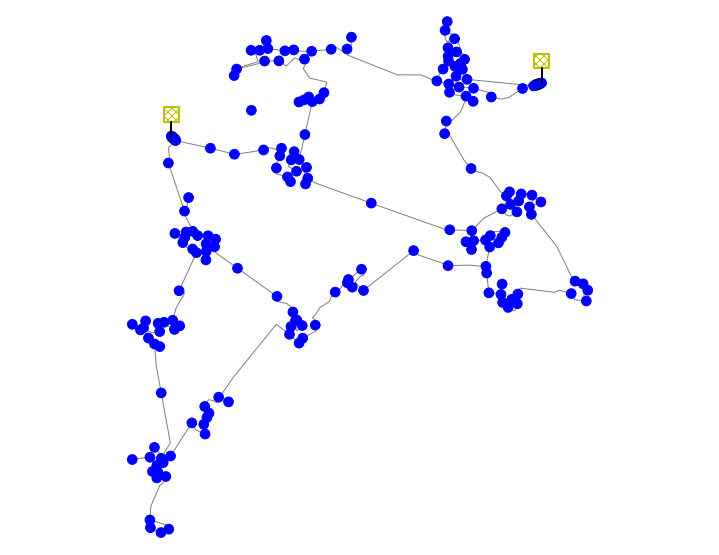

In [23]:
network = Init()
pp.runpp(network)
print(network)
#pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);

Length = 10.354036689259898km; Pb_bus=[] ; Pb_line=[193] ; Pb_trafo=[1] ; Transfo installed? = False
Max gen power = 20.002583120627214


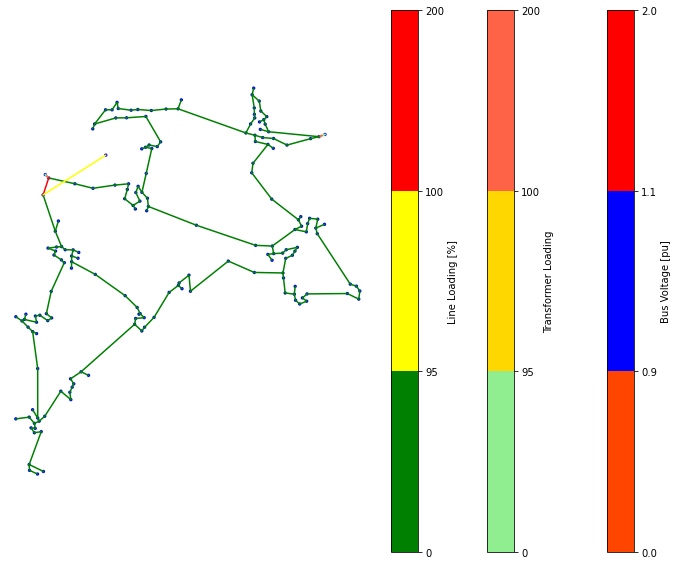

In [132]:
# Exemple with problem
p_max = 21
network = Init(pmw_gen = p_max)
PB,length,T = ConnexionGen(network,6,plot=True,saveName="Case1_5_21MW.png")
print(f'Length = {length}km; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxg = MaxPow(network,p_max=p_max+15); print(f'Max gen power = {maxg}')

Length changed [6.341336866518878, 0]; Pb_bus=[] ; Pb_line=[53, 62] ; Pb_trafo=[]
Max gen power = 29.6997722486551


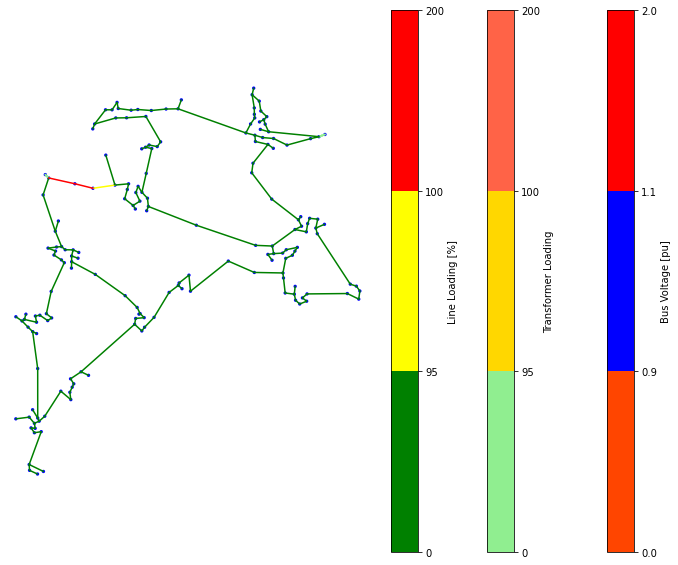

In [84]:
#Exemple of change trafo
PB,lent,_,_ = ChangeComp(network,PB[1],PB[2],PB[3],pmw_gen=p_max+10,saveName=None)
print(f'Length changed {lent}; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]}')
maxg = MaxPow(network,p_max = p_max+10); print(f'Max gen power = {maxg}')

Length = 8.860885146991015km and 4.369061502644277km ; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[] ; Transfo installed? = True
Max gen power = 67.35579624180994


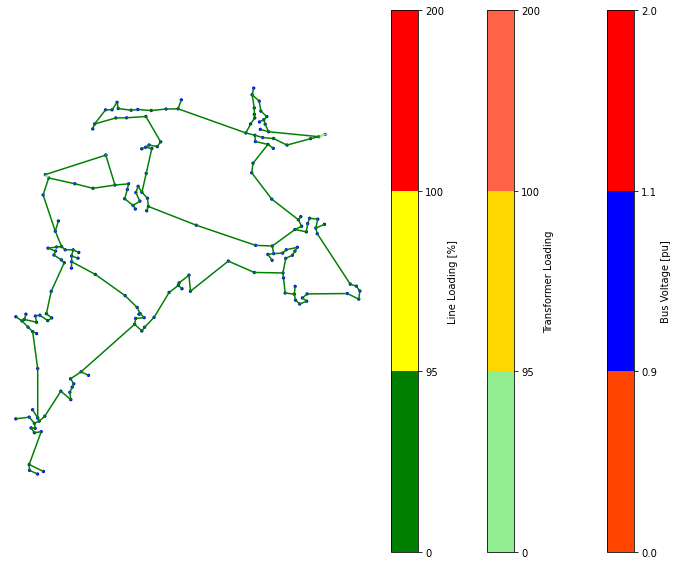

In [21]:
#Exemple DoubleConnexion
network = Init(pmw_gen = )
pp.runpp(network)
PB,LENGTH, T = DoubleCon(network,318,30,saveName=None)
print(f'Length = {LENGTH[0]}km and {LENGTH[1]}km ; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxg = MaxPow(network,p_max=70); print(f'Max gen power = {maxg}')

Length = 7.228051794501339km and 19.773784139793104 km and 10.202836365621211km and 13.242299668464021km; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[] ; Transfo installed? = False
Max gen power = 30.557285793502302


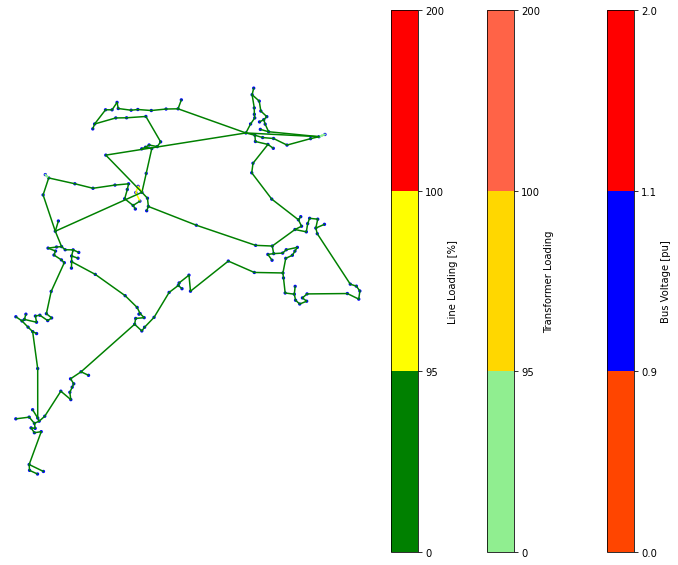

In [47]:
#Exemple other line in network
network = Init(pmw_gen=30)
pp.runpp(network)
_,length,T = ConnexionGen(network,110,plot=False,saveName=None)
_,length2,T = ConnexionGen(network,45,plot=False,saveName=None)
PB,length3 = CreateLine20kV(network,45,39,plot=False)
PB,length4 = CreateLine20kV(network,7,110,plot=True)
print(f'Length = {length}km and {length2} km and {length3}km and {length4}km; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]} ; Transfo installed? = {T}' )
maxg = MaxPow(network,p_max=60); print(f'Max gen power = {maxg}')

**From MaxPowWithoutProb:**
- Excel files with the standard type "490-AL1/64-ST1A 380.0" and "243-AL1/39-ST1A 20.0"

**From MaxPowerWithoutProbDouble:**
- Connecting 2 lines with node 29,30,31,36,42,44,46,48 will not achieve 30MW power avec the "243-AL1/39-ST1A 20.0" lines

### Optimisation

0.0%
25.0%
50.0%
75.0%


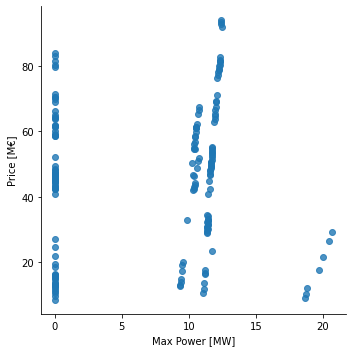

In [47]:
OptiScatter = ScatterPlotCase1(network)

0.0%
25.0%
50.0%
75.0%


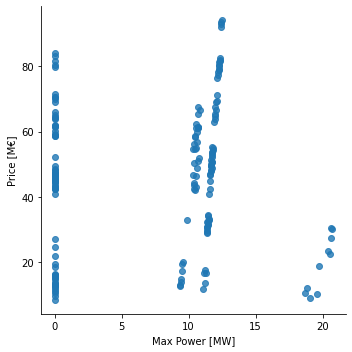

In [55]:
OptiScatter2 = ScatterPlotCase2(network)

0.0%
25.0%
50.0%
75.0%


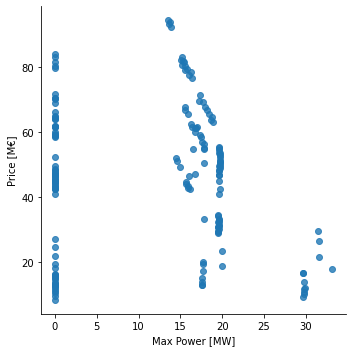

In [85]:
OptiScatter2Max = ScatterPlotCase2MAX(network)

In [78]:
# SUP30=[]
# for i in MaxGen['Bus connected'][MaxGen.Length <=9.63].array:
#     MAX = MaxPowerWithoutProbDouble(network,i,p_max=10)
#     print(i)
#     for maxi in [MAX[i] for i in range(0,179) if MAX[i][1]>=30]:
#         SUP30.append([i,maxi])

#MAX = MaxPowWithoutProb(network)
#MaxGen = pd.read_excel('Max_gen_oberrhein.xlsx')
#print([MAX[i] for i in range(0,179) if MAX[i][1]>20])
#MaxGen = pd.DataFrame(data = MAX)
#MaxGen.columns = ['Bus connected','MaxPower','Length','Trafo added']
#MaxGen.to_excel('Max_gen_oberrhein_20kV.xlsx') #save the datas

In [94]:
#Organized geodata same way as bus sheet
# GeoData = pd.DataFrame(index = network.bus.index)
# X,Y = [],[]
# for idx in network.bus.index:
#     X.append(network.bus_geodata.loc[idx][0])
#     Y.append(network.bus_geodata.loc[idx][1])
# GeoData['x'] = X
# GeoData['y'] = Y
# GeoData.to_excel('GeoDataOrdonnée.xlsx')